In [ ]:
####
####

# September 14, 2025.

#   Revised notebook code to combine the standardization of all reactions first, then remove duplicate reactions, then split dataset.
#   Changed a few standardization options including: removed -D fmap (add unique mapping numbers for any atoms not mapped),
#   and then added -D rmfnp (remove any reactant fragments not participating).

#   Note that a few file names changed...see the updated description of file names.

#   Moved the "ground truth" prediction comparison code to "Self-Study" as this was not in the original article, and it is unclear
#   how best to do the comparison and/or how relevant the comparison would be with the Lillymol RTSA algorithm.
#   Our test showed the number of matches was low, but our guess is that with adjusting standardization options, 
#   signature, and threshold parameters, it could change significantly -- so this requires more testing
#   and thought before any model evaluation conclusions.

#   Removed the complex unfinished code which attempted to add all precedent reactions to predictions w/ multiprocessing

####
####

# Lillymol Retrosynthetic Analysis Algorithm

V.F. Scalfani and A.M. Fernandez, University of Alabama Libraries

Fall 2024

## Anticipated Length of Workshop

~ 1 hour

## Important Notes

This notebook is part of the Retrosynthesis Workshop materials, which aim to introduce computational cheminformatics techniques for retrosynthesis prediction. Please note the following:

1. **Educational Purpose**: The tutorials are designed for educational purposes to help you understand cheminformatics strategies for predicting synthetic routes. They are not intended to provide practical laboratory guidance.

2. **Practical Limitations**: The methods demonstrated here are template-based and pattern-driven, meaning they rely on predefined reaction templates and do not fully capture real-world chemistry complexities. It is important to note that computational models can produce inaccurate or incomplete predictions due to simplifications and assumptions within the algorithms, as well as limitations in their training data. Any application of the predicted reactions would require signficant additional research, including a thorough review of the relevant literature, synthesis planning, and safety assessments. In addition, see the articles referenced throughout the Retrosynthesis Workshop notebooks to learn more about specific model limitations.

3. **Intellectual Property**: The retrosynthetic prediction techniques in the tutorials use reaction data (and/or computer models derived from this data) from U.S. patents for training purposes. Synthetic pathways suggested by these models could potentially be protected by intellectual property laws.

For further details, please refer to the [repository README](https://github.com/UA-Libraries-Research-Data-Services/retrosynthesis/blob/main/README.md), [data README](https://github.com/UA-Libraries-Research-Data-Services/retrosynthesis/blob/main/X_Data/AA_README_data) and references in the tutorials for more information.


## What is the purpose of this workshop?

The purpose of this workshop is to introduce the open-source LillyMol cheminformatics software and, specifically, its retrosynthesis implementation (https://github.com/EliLillyCo/LillyMol). This technique is deterministic and the key workflow pieces like standardization, signature calculations, and application of retrosynthesis to a target can all be implemented with the LillyMol provided command line programs. The version of LillyMol we will use (v6_cmake) is only distributed as C++ source code, so we will also discuss how to compile and use the software.

## Brief Description of Method

Reaction "signatures" (changing atoms in a reaction core) are extracted from a dataset of standardized and reversed reactions. The specificty of signature can be selected via a radius parameter, where a radius of, for example 2, would include the changing atoms and all atoms within 2 bonds of atoms in the core. The reaction signatures are a unique SMILES like format and can then be used to group reactions with the same signature (i.e., a reaction cluster). A representative reversed reaction is selected for each signature meeting a threshold (e.g., at least 10 occurences) and used as a reaction template. Templates are then used in the retrosynthetic algorithm to construct the signature for a substructure query on the target product [1]. 

Key terminology to keep in mind throughout this notebook:

- "fragments" for reactants and products
- "signatures" describe the reaction cores. This is a unique SMILES like format
- "reaction clusters" are grouped classes of signatures
- "reverse reaction template" a selected representative reaction for a particular signature

## References

[1] Watson, I. A.; Wang, J.; Nicolaou, C. A. A Retrosynthetic Analysis Algorithm Implementation. J Cheminform 2019, 11 (1), 1. https://doi.org/10.1186/s13321-018-0323-6.

[2] https://github.com/EliLillyCo/LillyMol

[3] Nicolaou, C. A.; Watson, I. A.; LeMasters, M.; Masquelin, T.; Wang, J. Context Aware Data-Driven Retrosynthetic Analysis. J. Chem. Inf. Model. 2020, 60 (6), 2728–2738. https://doi.org/10.1021/acs.jcim.9b01141.

[4] Schneider, N.; Stiefl, N.; Landrum, G. A. What’s What: The (Nearly) Definitive Guide to Reaction Role Assignment. J. Chem. Inf. Model. 2016, 56 (12), 2336–2346. https://doi.org/10.1021/acs.jcim.6b00564.

## Reuse Notes

Some of the code in this notebook was adapated from the supporting information rtsa_train.py file in Watson, I. A.; Wang, J.; Nicolaou, C. A. A Retrosynthetic Analysis Algorithm Implementation. J Cheminform 2019, 11 (1), 1. https://doi.org/10.1186/s13321-018-0323-6. It is licensed under the open source Apache License 2.0 and, therefore, this notebook code maintains the Apache License 2.0 license. A copy of the license can be found in this repository, named Lillymol_related_LICENSE

**We tried to follow the overall workflow presented in manuscript ([1] Watson, I. A. et al. J Cheminform 2019, 11 (1), 1. https://doi.org/10.1186/s13321-018-0323-6.) within our code for the retrosynthesis prediction parts. If you find mistakes/bugs, please let us know. Also note that we are using LillyMol version 6, which may differ from the version used in the article. In addition, we use a much smaller dataset for the training step, and a different dataset for testing.**

```
########################################################################
# Copyright 2018 Eli Lilly and Company 
# 
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License. 
# You may obtain a copy of the License at  
# 
#     http://www.apache.org/licenses/LICENSE-2.0  
# 
# Unless required by applicable law or agreed to in writing, software 
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
# See the License for the specific language governing permissions and 
# limitations under the License. 
########################################################################


------
Modifications:

Copyright 2024 Vincent F. Scalfani and Avery M. Fernandez, All rights reserved.

- Removed argparse command line functionality
- Split several functions into single commands for interactive use in Jupyter Notebooks
- Removed pandas workflow and replaced with built-in python data structures
- Updated Python 2 code to 3
- Adjusted LillyMol command line tool options for rxn_standardize
- Created a workflow to process a dataset of ~50,000 reactions
- Added a method to parse the retrosynthesis prediction data into a python dictionary
- Added depictions using RDKit
- Added a method to check if predictions match ground truth reaction using RDKit
- Added a method to rank precedent reactions using RDKit fingerprints and group precedent reactions with predictions
------

```

## Local Build of Lillymol 

Lillymol is a C++ cheminformatics library and is distributed as open source code.

Here is a recipe that works well for us on Ubuntu (tested on 22.04):

First install dependencies:

```
sudo apt update
sudo apt install build-essential zlib1g-dev libre2-dev cmake libeigen3-dev
```

Record GCC and cmake version for reference:

```
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
cmake version 3.22.1
```

Next download the source code. We use an older of LillyMol (version 6) that uses cmake for the build as it is much easier to compile: https://github.com/vfscalfani/LillyMol_6_cmake

Then, build the software!

```
cd LillyMol_6_cmake_main/src
mkdir build
cd build
cmake ..
make -j 4

```

That took about 1 minute to compile on my workstation. Next, we can test that the binaries were written:

```
cd LillyMol_6_cmake_main/src/build/build
ls

```
And now, test that they work:

```
./retrosynthesis
Must specify one of more radii via the -R option
/home/LillyMol_6_cmake-main/src/Molecule_Tools/retrosynthesis.cc compiled May 20 2024 11:28:58
Crude retrosynthetic testing tool
  -R <rad>      maximum radius around changing atoms
  -F <fname>    file containing single set of reaction files
  -G <fname>    file containing names of sets of reaction files
  -T <fname>    individual reactions
...
...
...

```

## Python Environment Setup

We are going to access LillyMol from within this notebook using python commands. As such, we will need a python environment. Here is a recipe with everyting we will use (same rdkit env as earlier in the workshop):

```
conda create --name retro_rdkit_env
conda activate retro_rdkit_env
conda install -c conda-forge rdkit jupyterlab numpy matplotlib pandas

```

## Description of Files Generated

* `_rxns_all.rsmi`: patentIDs and NameRxn mapped rxn SMILES from ref [4]
* `_out_clean.rsmi`: data from `_rxns_all.rsmi`, but now with SMILES extensions removed and a unique ID based on patent and row num
* `_out_fstd`: reaction SMILES and IDs after the first standardization step
* `_out_fstd.log`: log file associated with `_out_fstd`
* `_out_rstd_all`: second standardized reaction data
* `_out_rstd_all.log`: log associated with `_out_rstd`
* `_rxns_std_training.rsmi`: 80 % split of data after standardizations and removing duplicates
* `_rxns_std_testing.rsmi`: 20 % split of data after standardizations and removing duplicates
* `_out_lrsmi`: this is the `_rxns_std_training.rsmi` file, but now with reaction SMILES containing `+` instead of `.`
* `_rxns_std_training_reversed`: reverses the `_out_lrsmi` SMILES -- reactants>agents>products to products>agents>reactants. This is what we use for computing signatures.
* `_out_sig_bad`: signature file errors
* `_out_sig`: signature file
* `_out_sig.log`: log file associated with `_out_sig`
* `_out_sig_counts`: includes ID and changed atoms count
* `_RRT_T10`: reversed reaction template file
* `_prediction.rsmi/log`: prediction file outputs, contains predicted reactants and target
* `_testing_product_smiles`: just the products from `_rxns_std_testing`
* `_prediction_all.rsmi/log`: prediction file outputs from `_testing_product_smiles`, contains predicted reactants and target

## Preprocess Data

The original reference by Watson et al. [1] uses the large publicly available patent dataset from Lowe: https://figshare.com/articles/dataset/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873 for training and then a set of ~900 drug compounds for testing targets. For the purposes of this workshop demo and time, we will use a subset of 50,000 reactions from Schneider, et al. [4] for training. This will reduce the available knowledgebase of our model. For testing targets, we take a sample from the 50,000 reactions for the targets.

In [1]:
# unzip the data if necassary
# !unzip ../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.zip -d ../X_Data/

import os
import subprocess

# Path to the expected unzipped file
unzipped_file_path = '../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.csv'

# Check if the file exists
if not os.path.exists(unzipped_file_path):
    # Unzip the file if the .csv file does not exist
    subprocess.run(["unzip", "../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.zip", "-d", "../X_Data/"])
else:
    print("File is already unzipped.")

File is already unzipped.


In [2]:
# Load Schneider 50,000 rxns (dataset B from supp info)
# Schneider, N. et al. J. Chem. Inf. Model. 2016, 56 (12), 2336–2346. https://doi.org/10.1021/acs.jcim.6b00564.
import csv
rxns = []
with open("../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.csv", "r") as infile:
    reader = csv.reader(infile, delimiter=',')
    next(reader) # skip header
    for row in reader:
        rxnSmiles = row[2] # rxnSmiles_Mapping_NameRxn
        patentID = row[1]
        rxns.append((rxnSmiles,patentID))

In [3]:
# Write all reactions to file
with open("./temp/_rxns_all.rsmi", 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter='\t')
    for row in rxns:
        writer.writerow(row)

In [4]:
# Clean up reactions and write file with unique IDs
rxns_all = []
with open("./temp/_rxns_all.rsmi", "r") as infile:
    reader = csv.reader(infile, delimiter='\t')
    for idx,row in enumerate(reader):

        try:
            # generating new, unique id column   
            patentID = row[1] + "__" + str(idx)

            # cleaning additional symbols from rsmiles column (should remove any SMILES extensions after a space)
            rxnSmiles = row[0]
            if ' ' in rxnSmiles:
               cleaned_rxnSmiles = rxnSmiles.split(' ')[0]
               extensions = rxnSmiles.split(' ')[1]
            else:
               cleaned_rxnSmiles = rxnSmiles
               extensions = None
          
            rxns_all.append((cleaned_rxnSmiles,patentID))
        except Exception as error:
            # skip bad line input
            continue

# Write to file
with open("./temp/_out_clean.rsmi", 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter=' ')
    for row in rxns_all:
        writer.writerow(row)

## Set Path for LillyMol Build

In [5]:
# We need to specify the path of the LillyMol binaries
import os
import subprocess

# this is assuming that the LillyMol Binaries are in the /retrosynthesis folder
lillymol_path = "../LillyMol_6_cmake/src/build/build/"

In [ ]:
# Test if we can run one of the binaries
# If succesful, you should see the help file.
cmd = lillymol_path + "rxn_standardize"
subprocess.call([cmd], shell=True)

## Standardization Part 1

Here are the standardization options from reference [1] that we could infer from the article and supporting information code. We had to adapt and change some of the rxn_standardize options (mostly in part 2) from the article because the version of LillyMol we are using has different options. However, we think we captured the important and necassary steps for the standardization workflow described in the article.

In [7]:

"""
Here is what the options mean:

-v, verbose
-c, discard chirality on input
-X igbad, discard bad reactions
-s, reading reaction smiles
-K, fix alternating kekule issues

"""

# get the folder path of where files are
fp = "./temp/"

std1 = lillymol_path + "rxn_standardize -v -c -X igbad -s -K " + fp + "_out_clean.rsmi" + " > " + fp + "_out_fstd" + " 2>" + fp + "_out_fstd.log\n"
subprocess.call([std1], shell=True)

0

## Standardization Part 2

See standardization option change note above.

In [8]:
"""
Here is what the options mean:

-s, reading reaction smiles
-X rmdmap, discard reactions containing duplicate atom map numbers
-X igbad, discard bad reactions
-X nclf, discard reactions where there is no change in the largest fragment
-v, verbose
-C 40, discard any reactions where the largest reagent has more than 40 atoms
-K, fix alternating kekule issues
-E autocreate, automatically create new elements when encountered (e.g., R1 can be a valid element)

-D rmdr, remove duplicate reactants
-D rmdp, remove duplicate products
-D rmda, remove duplicate agents
-D rmnmap, remove any component with no atom mapping at all
-D rmdup, remove components that are shown as both reactants and products
-D rmfnp, remove reactants fragments not participating
-X rmiso, discard reactions containing isotopic atoms
-X rmmp, discard reactions that have multiple products

"""
fp = "./temp/"
std2 = lillymol_path + "rxn_standardize -s -X rmdmap -X igbad -X nclf -v -C 40 -K -E autocreate " \
     + "-D rmdr -D rmdp -D rmda -D rmnmap -D rmdup -D rmfnp -X rmiso -X rmmp " \
		+  fp +"_out_fstd" + " > " + fp + "_out_rstd_all" + " 2>" + fp + "_out_rstd_all.log\n"
subprocess.call([std2], shell=True)

0

In [9]:
# Load the standardized reaction data
rxns_standardized = []
with open("./temp/_out_rstd_all", "r") as infile:
    reader = csv.reader(infile, delimiter=' ')
    next(reader) # skip header
    for row in reader:
        rxnSmiles = row[0] # rxnSmiles_Mapping_NameRxn
        ID = row[1]
        rxns_standardized.append((rxnSmiles,ID))

In [10]:
len(rxns_standardized)

45185

In [11]:
# Remove duplicates
# Not sure how to do this with LillyMol, so we will use RDKit temporarily here.

from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Validate RDKit can read reaction
def validate_reaction(smiles):
    """
    Check if a reaction is valid
    """
    try:
        # attempt to parse rxn
        reaction = rdChemReactions.ReactionFromSmarts(smiles, useSmiles=True)
        # attempt to sanitize rxn
        rdChemReactions.SanitizeRxn(reaction)
    except Exception as e:
        return None
    return reaction

# Compute unmapped canonicalized rxn SMILES, so we can remove duplicates
def get_unmapped_canonical_smiles(rxn):
    rdChemReactions.RemoveMappingNumbersFromReactions(rxn)
    canonical_unmapped = rdChemReactions.ReactionToSmiles(rxn, canonical=True)
    return canonical_unmapped

# Process reactions
canonical_rxns = []
IDs_to_filter = []
for rxn_smiles, rxn_id in rxns_standardized:
    rxn = validate_reaction(rxn_smiles)
    
    # Collect IDs for any reactions that RDKit can not parse
    # We will filter these out, otherwise we can't tell if they are duplicates
    if rxn is None:
        IDs_to_filter.append(rxn_id)

    if rxn is not None:
        rxn_unmapped = get_unmapped_canonical_smiles(rxn)
        canonical_rxns.append((rxn_unmapped,rxn_id))
       

In [12]:
# Now loop through canonical reactions and identify any duplicates, track by ID and add to IDs_to_filter

seen_smiles = {}
for smiles, rxn_id in canonical_rxns:
    if smiles in seen_smiles:
        # Duplicate found, add current ID to filter list
        # print(smiles, rxn_id)
        IDs_to_filter.append(rxn_id)
    else:
        seen_smiles[smiles] = rxn_id

print("Number of reactions not parsed and duplicates: " + str(len(IDs_to_filter)))
# Filter out duplicates and rxns that did not parse in reactions_standardized based on IDs in IDs_to_filter
rxns_standardized_filtered = [(smiles, rxn_id) for smiles, rxn_id in rxns_standardized if rxn_id not in IDs_to_filter]


Number of reactions not parsed and duplicates: 334


In [13]:
len(rxns_standardized_filtered)

44851

In [14]:
# Note that we filtered based on IDs, so this leaves the rxns_standardized filtered dataset processed by the LillyMol toolkit.
# We didn't change the rxns_standardized_filtered reactions with RDKit, only used RDKit to identify duplicates.
rxns_standardized_filtered[0:3]

[('Cl[C:1](=[O:2])[O:3][CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8]1.[CH3:9][CH2:10][O:11][C:12]1=[CH:13][CH:14]=[C:15]([O:16][C:17]2=[N:18][CH:19]=[N:20][C:21]3=[C:22]2[CH:23]=[N:24][N:25]3[CH:26]2[CH2:27][CH2:28][NH:29][CH2:30][CH2:31]2)[C:32]([F:33])=[CH:34]1>>[C:1](=[O:2])([O:3][CH:4]1[CH2:5][CH2:6][CH2:7][CH2:8]1)[N:29]1[CH2:28][CH2:27][CH:26]([N:25]2[C:21]3=[C:22]([C:17](=[N:18][CH:19]=[N:20]3)[O:16][C:15]3=[CH:14][CH:13]=[C:12]([O:11][CH2:10][CH3:9])[CH:34]=[C:32]3[F:33])[CH:23]=[N:24]2)[CH2:31][CH2:30]1',
  'US08188098B2__4'),
 ('Br[C:1]1=[C:6]([N:5]=[CH:4][N:2]1[CH3:3])[C:7]1=[CH:8][C:9](=[CH:12][CH:13]=[N:14]1)[C:10]#[N:11].OB(O)[C:15]1=[CH:16][CH:17]=[C:18]([N:19]2[CH:20]=[CH:21][CH:22]=[N:23]2)[CH:24]=[CH:25]1>>[C:1]1(=[C:6]([N:5]=[CH:4][N:2]1[CH3:3])[C:7]1=[CH:8][C:9](=[CH:12][CH:13]=[N:14]1)[C:10]#[N:11])[C:15]1=[CH:16][CH:17]=[C:18]([N:19]2[CH:20]=[CH:21][CH:22]=[N:23]2)[CH:24]=[CH:25]1',
  'US20140275084A1__5'),
 ('Br[C:1]1=[C:2]([O:3][CH:4]2[CH2:5][CH2:6][CH2:7][CH2:8][O:9]2)[C

In [15]:
# Now we want to split the data into training and testing data
# We will use a 80/20 split for demonstration
# A good idea would be to try a 80/10/10 split for validating different parameters such as signature radius and threshold

import random
seed = 21
# Shuffle the items in place
random.seed(seed)
random.shuffle(rxns_standardized_filtered)

# 80% training, 20% testing
split_value = int(len(rxns_standardized_filtered) * 0.8)
training_data = rxns_standardized_filtered[:split_value]
testing_data = rxns_standardized_filtered[split_value:]

print(len(training_data))
print(len(testing_data))

# Write to file
with open("./temp/_rxns_std_training.rsmi", 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter=' ')
    for row in training_data:
        writer.writerow(row)

with open("./temp/_rxns_std_testing.rsmi", 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter=' ')
    for row in testing_data:
        writer.writerow(row)

35880
8971


## Convert training reaction dataset to plus rsmi and reverse reactions

In [16]:
# convert to lrsmi (plusrsmi) format
fp = "./temp/"
cmd_lrsmi = r'sed "s/\./+/g" ' + fp + "_rxns_std_training.rsmi" + ' > ' + fp + "_out_lrsmi"
subprocess.call([cmd_lrsmi], shell=True)

0

In [17]:
# Reverse rxn SMILES function
# given an rsmi or lrsmi (reaction smiles string)
# reverse the parts and return the result

def reverse_smi(rsmi, debug=False):

    # separate into reaction and name
    rxnAndName = rsmi.split(" ")
    if len(rxnAndName) < 2:
        raise ValueError("Error in smiles - Expected a smiles string followed by a space, then a compound name")

    thisRxn = rxnAndName[0]
        
    # now split the rxn parts - reactants, agents, and products 

    rxnParts = thisRxn.split(">")  # split the rxn part
    if len(rxnParts) != 3: 
        raise ValueError('Error in reaction smiles -expected three parts : "' + rsmi + '"')

    outString = rxnParts[2] + '>' + rxnParts[1] + '>' + rxnParts[0]
    for nameIndex in range(1, len(rxnAndName)):  
        # name might have had spaces and so would be split into multiple parts
        outString += ' ' + rxnAndName[nameIndex]

    return outString

In [18]:
# reverse: rsmi to revrsmi
# reactants>agents>products to products>agents>reactants
with open("./temp/_out_lrsmi", 'r') as ins, open("./temp/_rxns_std_training_reversed", 'w') as outs:
    for line in ins:
        outline = reverse_smi(line)
        outs.write(outline)

In [19]:
# OK the `_rxns_std_training_reversed`is the final file we need for the training calculations
# So, I am going to move it to the main current directory
!mv ./temp/_rxns_std_training_reversed .

In [20]:
# look at first 3 lines
!head -n3 _rxns_std_training_reversed

[C:1](=[O:2])([C:3]1=[CH:4][N:5]=[C:6]2[CH:7]=[C:8]([Cl:9])[CH:10]=[CH:11][N:12]12)[NH:31][C:30]1=[CH:29][CH:28]=[CH:27][C:26]2=[C:32]1[C:14](=[N:15][N:16]2[CH2:17][C:18]1=[N:25][N:21]([CH:20]=[CH:19]1)[CH:22]([CH3:23])[CH3:24])[CH3:13]>>CCO[C:1](=[O:2])[C:3]1=[CH:4][N:5]=[C:6]2[CH:7]=[C:8]([Cl:9])[CH:10]=[CH:11][N:12]12+[CH3:13][C:14]1=[N:15][N:16]([CH2:17][C:18]2=[N:25][N:21]([CH:20]=[CH:19]2)[CH:22]([CH3:23])[CH3:24])[C:26]2=[C:32]1[C:30](=[CH:29][CH:28]=[CH:27]2)[NH2:31] US20130274244A1__32665
[C:1]1([NH2:13])=[C:2]([N+:3](=[O:4])[O-:5])[CH:6]=[N:7][C:8]2=[CH:9][S:10][CH:11]=[C:12]12>>Cl[C:1]1=[C:2]([N+:3](=[O:4])[O-:5])[CH:6]=[N:7][C:8]2=[CH:9][S:10][CH:11]=[C:12]12+[NH3:13] US04753951__20658
[C:1]1(=[CH:8][C:6](=[O:7])[N:4]([CH3:5])[CH:3]=[CH:2]1)[C:9]1=[CH:10][C:11]2=[C:12]([CH:13]=[N:14]1)[O:15][CH:16]([CH:17]1[CH2:18][CH2:19][N:20]([C:21](=[O:27])[O:22][C:23]([CH3:24])([CH3:25])[CH3:26])[CH2:28][CH2:29]1)[CH2:30]2>>CC1(C)OB([C:1]2=[CH:8][C:6](=[O:7])[N:4]([CH3:5])[CH:3]=[CH:2]

## Compute Reaction Signatures

In [21]:
# given clean, reversed, standardized, with plus instead of dots rsmi file
# extract reaction signatures

"""
-v, verbose output
-r <rad>,  radius from changing atoms to signature
-C <fname>, write changed atom counts to <fname>
-F <fname>, ignore otherwise bad reactions and write them to <fname>

"""

# This generates 3 signatures for each reaction (radius = 0,1,2)
cmd_sig = lillymol_path + "rxn_signature -v -r 0,1,2 -C " + "_out_sig_counts" + \
		" -F " + "_out_sig_bad" + " " + "_rxns_std_training_reversed" + " > " + "_out_sig" + " 2> " + "_out_sig" + ".log\n"
subprocess.call([cmd_sig], shell=True)

0

## Filter Signatures

In [22]:
# Read in signature file
signatures = []
with open("_out_sig", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 6:
            sigrsmi, na, id, sigr0, sigr1, sigr2 = split_data
            signatures.append({
                'sigrsmi': sigrsmi,
                'na': na,
                'id': id,
                'sigr0': sigr0,
                'sigr1': sigr1,
                'sigr2': sigr2
            })

In [23]:
signatures[0:3]

[{'sigrsmi': '[1C:1](=[O:2])([C:3]1=[CH:4][N:5]=[C:6]2[CH:7]=[C:8]([Cl:9])[CH:10]=[CH:11][N:12]12)[1NH:31][C:30]1=[CH:29][CH:28]=[CH:27][C:26]2=[C:32]1[C:14](=[N:15][N:16]2[CH2:17][C:18]1=[N:25][N:21]([CH:20]=[CH:19]1)[CH:22]([CH3:23])[CH3:24])[CH3:13]>>CCO[C:1](=[O:2])[C:3]1=[CH:4][N:5]=[C:6]2[CH:7]=[C:8]([Cl:9])[CH:10]=[CH:11][N:12]12+[CH3:13][C:14]1=[N:15][N:16]([CH2:17][C:18]2=[N:25][N:21]([CH:20]=[CH:19]2)[CH:22]([CH3:23])[CH3:24])[C:26]2=[C:32]1[C:30](=[CH:29][CH:28]=[CH:27]2)[NH2:31]',
  'na': '2',
  'id': 'US20130274244A1__32665',
  'sigr0': '[10035O]=[5745C][8747N]',
  'sigr1': '[10035O]=[7447C]([10449N][4982C])[4909C]',
  'sigr2': '[10035O]=[9149C]([12151N][4982C](:[5141C]):[4979C])[4909C](:[8146N]):[4906C]::3,4:3,5:6,7:6,8:'},
 {'sigrsmi': '[1C:1]1([1NH2:13])=[C:2]([N+:3](=[O:4])[O-:5])[CH:6]=[N:7][C:8]2=[CH:9][S:10][CH:11]=[C:12]12>>Cl[C:1]1=[C:2]([N+:3](=[O:4])[O-:5])[CH:6]=[N:7][C:8]2=[CH:9][S:10][CH:11]=[C:12]12+[NH3:13]',
  'na': '2',
  'id': 'US04753951__20658',
  'sig

In [24]:
len(signatures)

35880

In [25]:
# Select radius (0,1, or 2)
# See article [1] for more information
# We are only using radius 1 here, but you would want to also try 0,2.
# See, for example Tables 1 and 2 to see how this affects results.
radius = 1
radius = 'sigr'+str(radius)
print(radius)

sigr1


In [26]:
# Create a count of unique radius signatures
# Some reactions will have the same reaction signature
count = {}
for item in signatures:
    if item[radius] in count:
        count[item[radius]] += 1
    else:
        count[item[radius]] = 1

len(count)

6131

In [27]:
# Sort the count
sorted_count = sorted(count.items(), key=lambda x: x[1], reverse=True)
sorted_count[0:10] # show top 10 signatures

[('[13438O][4043C]=[10035O]', 2582),
 ('[10444N][4982C]', 1298),
 ('[13438O][4982C]', 671),
 ('[10035O]=[7447C]([10449N][4039C])[4982C]', 505),
 ('[4979C]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:', 468),
 ('[4982C][13443O][7443C][4039C]', 437),
 ('[10035O]=[7447C]([10449N][4982C])[4982C]', 428),
 ('[4941C][11351N][4941C]::0,1:1,2:', 397),
 ('[4039C][7443C][11354N]([4941C])[4941C]::2,3:2,4:', 314),
 ('[10444N][4039C]', 310)]

In [28]:
# find signatures meeting frequency threshold
# See article [1] for more information

min_threshold = 10 # must have at least 10 occurences
filtered_sig_count = {k: v for k, v in count.items() if v >= min_threshold}

# write frequency distribution for each signature string in file for reference
# with open("_RRT_T10_R2.freqdistr", 'w') as outfile:
#    for k, v in filtered_sig_count.items():
#        outfile.write(k + ' ' + str(v) + '\n')

In [29]:
list(filtered_sig_count.items())[0:5]

[('[10035O]=[7447C]([10449N][4982C])[4909C]', 148),
 ('[7985N]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:', 170),
 ('[13439O]=[7447C]([4982C])[4034C]', 10),
 ('[5141C]:[11318N]([7443C][4982C]):[4909C]::0,1:1,4:', 44),
 ('[7042N]#[7445C][8386C](:[4982C]):[4979C]::2,3:2,4:', 20)]

In [30]:
print(f"Number of signatures meeting threshold of {min_threshold} is {len(filtered_sig_count)}")

Number of signatures meeting threshold of 10 is 553


In [31]:
# now we filter the original signature data
# so that we limit the data to signatures above the threshold
filtered_signatures = []
for item in signatures:
    if item[radius] in filtered_sig_count:
        filtered_signatures.append(item)

print(len(filtered_signatures))

25081


In [32]:
# And remove duplicates, so that now we have only one representative reaction set for each unique signature
filtered_signatures_first = [] # first rxn that matches signature
seen = set()

for item in filtered_signatures:
    sig = item[radius]
    if sig not in seen:
        # Add the element to the filtered_result list
        filtered_signatures_first.append(item)
        # Add the radius_value to the seen set
        seen.add(sig)

print(len(filtered_signatures_first))

553


In [33]:
# pull out data from _rxns_std_training_reversed file and merge with `filtered_signatures_first` to get the final data
with open("_rxns_std_training_reversed", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 2:
            stdrsmi, id = split_data
            for item in filtered_signatures_first:
                if item['id'] == id:
                    item['stdrsmi'] = stdrsmi
                    break

In [34]:
filtered_signatures_first[0:3]

[{'sigrsmi': '[1C:1](=[O:2])([C:3]1=[CH:4][N:5]=[C:6]2[CH:7]=[C:8]([Cl:9])[CH:10]=[CH:11][N:12]12)[1NH:31][C:30]1=[CH:29][CH:28]=[CH:27][C:26]2=[C:32]1[C:14](=[N:15][N:16]2[CH2:17][C:18]1=[N:25][N:21]([CH:20]=[CH:19]1)[CH:22]([CH3:23])[CH3:24])[CH3:13]>>CCO[C:1](=[O:2])[C:3]1=[CH:4][N:5]=[C:6]2[CH:7]=[C:8]([Cl:9])[CH:10]=[CH:11][N:12]12+[CH3:13][C:14]1=[N:15][N:16]([CH2:17][C:18]2=[N:25][N:21]([CH:20]=[CH:19]2)[CH:22]([CH3:23])[CH3:24])[C:26]2=[C:32]1[C:30](=[CH:29][CH:28]=[CH:27]2)[NH2:31]',
  'na': '2',
  'id': 'US20130274244A1__32665',
  'sigr0': '[10035O]=[5745C][8747N]',
  'sigr1': '[10035O]=[7447C]([10449N][4982C])[4909C]',
  'sigr2': '[10035O]=[9149C]([12151N][4982C](:[5141C]):[4979C])[4909C](:[8146N]):[4906C]::3,4:3,5:6,7:6,8:',
  'stdrsmi': '[C:1](=[O:2])([C:3]1=[CH:4][N:5]=[C:6]2[CH:7]=[C:8]([Cl:9])[CH:10]=[CH:11][N:12]12)[NH:31][C:30]1=[CH:29][CH:28]=[CH:27][C:26]2=[C:32]1[C:14](=[N:15][N:16]2[CH2:17][C:18]1=[N:25][N:21]([CH:20]=[CH:19]1)[CH:22]([CH3:23])[CH3:24])[CH3:13]>>C

In [35]:
# Output to a csv file column 1 is the template, column 2 is the id
# This is the final template file we need for predictions!
with open("_RRT_T10", 'w') as outfile:
    for item in filtered_signatures_first:
        outfile.write(item['stdrsmi'] + ' ' + item['id'] + ' ' + item[radius] + '\n')

## Retrosythesis Prediction

In [36]:
# Move test reactions file into main directory
!mv ./temp/_rxns_std_testing.rsmi .

In [37]:
# Let's grab a test rxn
# !head -n 1 _rxns_std_testing.rsmi > test_rxn1.rsmi

!sed -n '158p' _rxns_std_testing.rsmi > test_rxn1.rsmi

In [38]:
# and now get the product as the test target (everything after >>)
!sed -n 's/.*>>//p' test_rxn1.rsmi > test_target1.smi

In [39]:
# Try one target product
!cat test_target1.smi

[CH3:1][C:2]1([CH3:3])[CH2:4][N:5]([CH2:6][C:7]2=[CH:8][CH:9]=[CH:10][N:11]=[CH:12]2)[C:13]2=[C:19]1[CH:18]=[C:16]([CH:15]=[CH:14]2)[O:17][C:21](=[O:20])[NH:22][CH2:23][C:24]1=[CH:25][CH:26]=[CH:27][CH:28]=[CH:29]1 US20110294850A1__24709


In [40]:
retro = lillymol_path + "retrosynthesis -Z -z -Y all -X rmiso -X kg -X kekule -X ersfrm " \
     + "-a 2 -q f -v -R 1 -I _RRT_T10 -P UST:AZUCORS test_target1.smi > _prediction.rsmi 2> _prediction.log"

"""
-Z, ignore reactions that cannot be constructed
-z, ignore reactions with no changing atoms
-Y all, all standardizations of functional groups

-X rmiso, remove isotopes from incoming molecules
-X kg, keep going after a test failure
-X kekule, preserve Kekule forms
-X ersfrm, add an extra output with small fragments (-a) removed

-a 2, do NOT write products with fewer than 2 atoms
-q f, use the reaction file name as the reaction name
-v, verbose
-R 1, maximum radius around changing atoms

-I file, reaction SMILES input (RRTs, the reversed reaction templates)
-P, atom typing specification - determine changing atoms and searching match conditions (default=UST:AZUCORS)

"""
subprocess.call([retro], shell=True)

0

In [44]:
# Let's look at the data
# SPFRM.0 - I think this means no fragments removed from prediction
# SPFRM.1 - I think this means that fragments were removed from prediction
!cat _prediction.rsmi

CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1 US20110294850A1__24709 PARENT
OC(=O)OC(C)(C)C.NCc1ccccc1.O=COc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C US20110294850A1__24709 via US20140179567A1__16206 [10039O][7447C](=[10035O])[10449N][4039C] _RRT_T10 R 1 ALL
OC(=O)OC(C)(C)C.NCc1ccccc1.O=COc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C US20110294850A1__24709 via US20140179567A1__16206 [10039O][7447C](=[10035O])[10449N][4039C] _RRT_T10 R 1 SPFRM.0
O=COc1ccc2N(CC(c2c1)(C)C)Cc1ccc[n]c1 US20110294850A1__24709 via US20140179567A1__16206 [10039O][7447C](=[10035O])[10449N][4039C] _RRT_T10 R 1
NCc1ccccc1 US20110294850A1__24709 via US20140179567A1__16206 [10039O][7447C](=[10035O])[10449N][4039C] _RRT_T10 R 1
OC(=O)OC(C)(C)C US20110294850A1__24709 via US20140179567A1__16206 [10039O][7447C](=[10035O])[10449N][4039C] _RRT_T10 R 1
CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1 US20110294850A1__24709 PARENT
Cl.O=C(Oc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C)NCc1ccccc1 US20110294850A1__24709 via US20090156642A1__168

In [45]:
# parse prediction data into a dictionary
predictions = {}
with open("_prediction.rsmi", 'r') as infile:
    for line in infile:
        prediction_data = line.strip().split()
        if prediction_data[-1] == "PARENT":
            product = prediction_data[0]
            parent_id = prediction_data[1]
            if parent_id not in predictions:

                predictions[parent_id] = {
                    "product": product,
                    "predictions": []
                }
            continue


        if prediction_data[-1] != "PARENT": #, "SPFRM.1", "SPFRM.0"]:
            reactants = prediction_data[0]
            parent_id = prediction_data[1]
            retro_type = prediction_data[-1]
            template = prediction_data[3]
            signature = prediction_data[4]
            predictions[parent_id]["predictions"].append({
                "Reactants": reactants,
                "Template": template,
                "Signature": signature,
                "Retro Type": retro_type
            })

In [46]:
# Filter for retro type ALL
filtered_predictions = {
   key: {
       'product': value['product'],
       'predictions': [pred for pred in value['predictions'] if pred['Retro Type'] == 'ALL'],
       'count': sum(1 for pred in value['predictions'] if pred['Retro Type'] == 'ALL')
   }
   for key, value in predictions.items()
}


In [47]:
# # Filter for retro type SPFRM.1 or SPFRM.0
# filtered_predictions = {
#     key: {
#         'product': value['product'],
#         'predictions': [
#             pred for pred in value['predictions']
#             if pred['Retro Type'] in ('SPFRM.1', 'SPFRM.0')
#         ],
#         'count': sum(
#             1 for pred in value['predictions']
#             if pred['Retro Type'] in ('SPFRM.1', 'SPFRM.0')
#         )
#     }
#     for key, value in predictions.items()
# }


In [48]:
# Create rxn syntax for predictions
for key,value in filtered_predictions.items():
    product = value['product']
    for prediction in value['predictions']:
        rxn = product + ">>" + prediction["Reactants"] 
        prediction["predicted_rxn_smi"] = rxn

In [49]:
filtered_predictions

{'US20110294850A1__24709': {'product': 'CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1',
  'predictions': [{'Reactants': 'OC(=O)OC(C)(C)C.NCc1ccccc1.O=COc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C',
    'Template': 'US20140179567A1__16206',
    'Signature': '[10039O][7447C](=[10035O])[10449N][4039C]',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1>>OC(=O)OC(C)(C)C.NCc1ccccc1.O=COc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C'},
   {'Reactants': 'Cl.O=C(Oc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C)NCc1ccccc1',
    'Template': 'US20090156642A1__16890',
    'Signature': '[7985N]:[8383C]:[4979C]::0,1:1,2:',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1>>Cl.O=C(Oc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C)NCc1ccccc1'},
   {'Reactants': 'Br.O=C(Oc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C)NCc1ccccc1',
    'Template': 'US20150025280A1__2577',
    'Signature': '[4982C]:[8383C]:[4979C]::0,1:1,2:',
    'Retro Type': 'ALL',
 

In [50]:
# for rxn in filtered_predictions.values():
#     for prediction in value['predictions']:
#         print(prediction)

In [51]:
# Now let's depict the predictions with RDKit
from rdkit import rdBase
print('RDKit version:',rdBase.rdkitVersion)

RDKit version: 2025.03.6


US20110294850A1__24709 CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1

Sequence 0

Template Information (R2): US20140179567A1__16206
[10039O][7447C](=[10035O])[10449N][4039C]


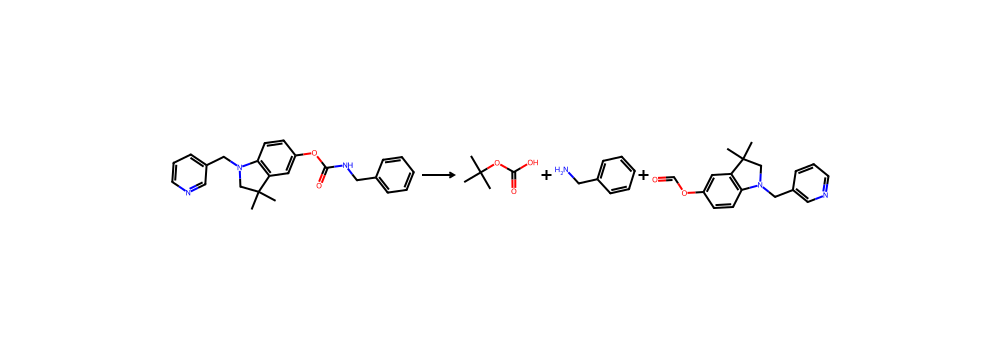

Sequence 1

Template Information (R2): US20090156642A1__16890
[7985N]:[8383C]:[4979C]::0,1:1,2:


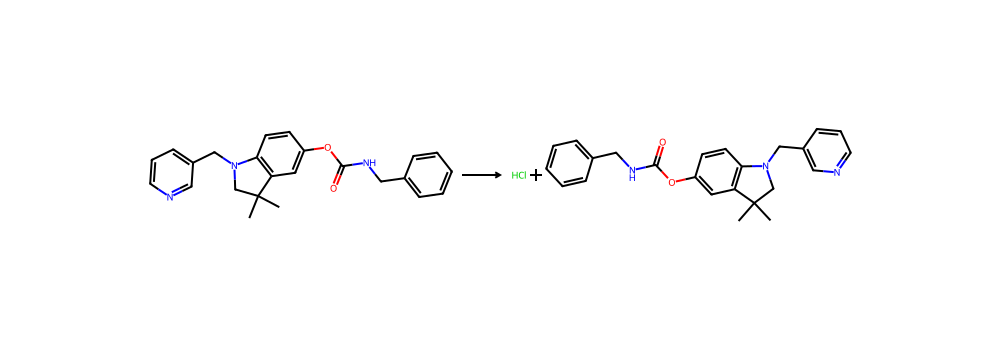

Sequence 2

Template Information (R2): US20150025280A1__2577
[4982C]:[8383C]:[4979C]::0,1:1,2:


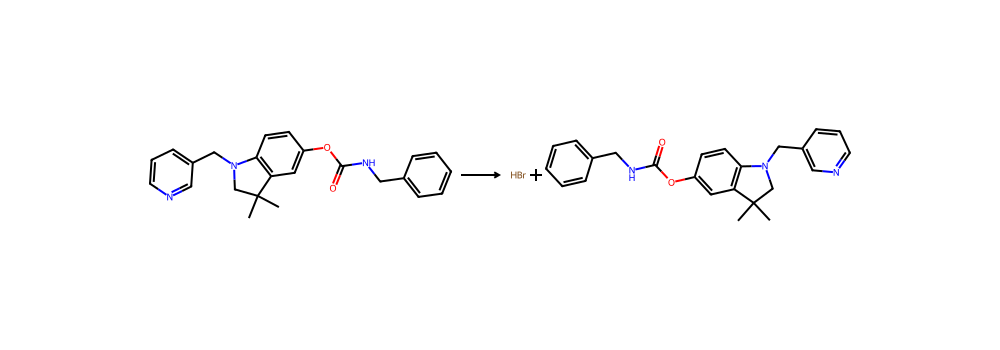

Sequence 3

Template Information (R2): US05728650__23507
[7045N][7443C][4982C]


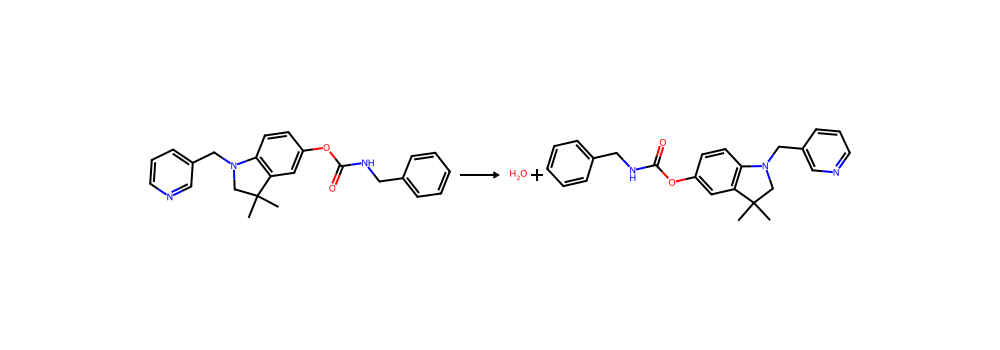

Sequence 4

Template Information (R2): US20120029023A1__47856
[4979C]:[8383C]:[4979C]::0,1:1,2:


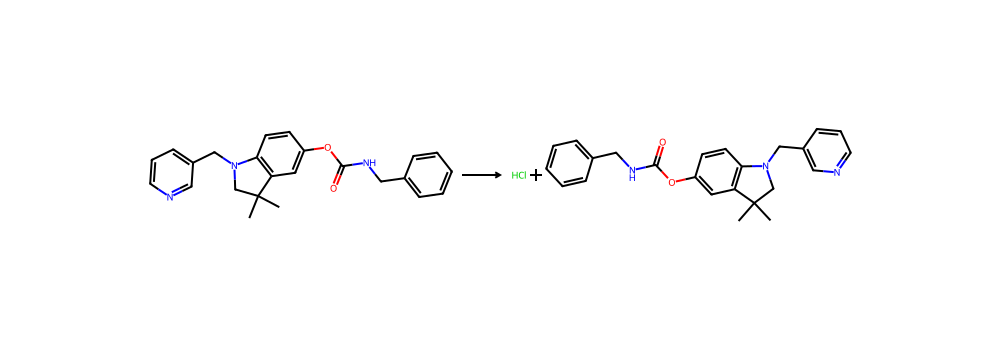

Sequence 5

Template Information (R2): US20080076924A1__19553
[7985N]:[8383C]:[4982C]::0,1:1,2:


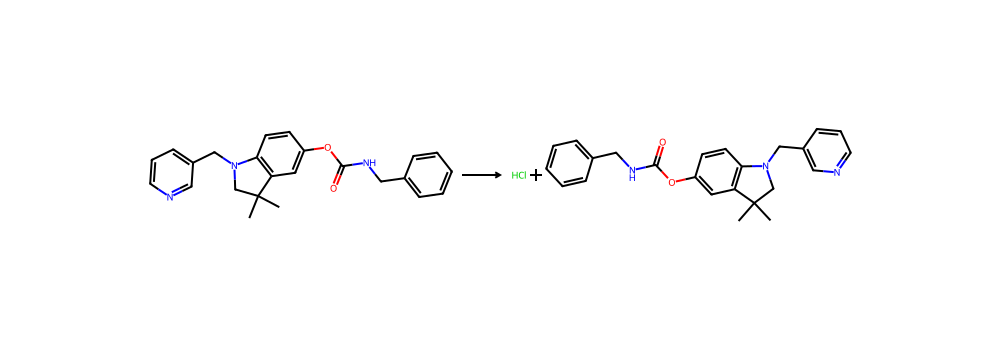

Sequence 6

Template Information (R2): US20020052498A1__3305
[10035O]=[7447C]([13443O][4982C])[10449N][4039C]


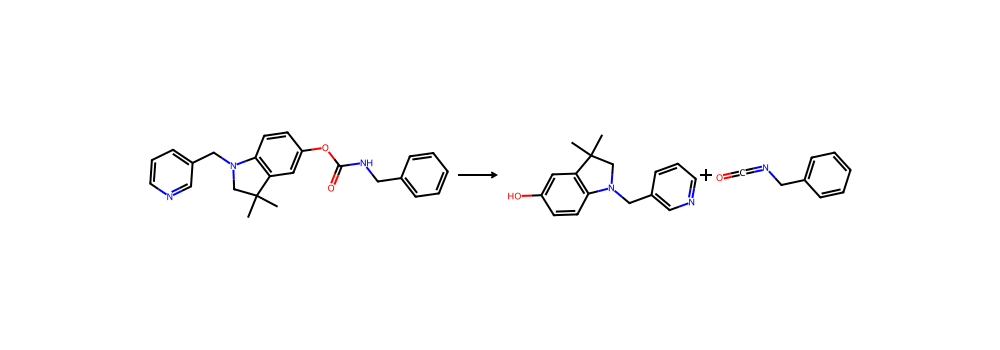

In [52]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

for key, value in filtered_predictions.items():
    print(key, value["product"] +"\n")
    for idx, prediction in enumerate(value['predictions']):
        print("Sequence " + str(idx) +"\n")
        print("Template Information (R2): " + prediction["Template"] + "\n"+ prediction["Signature"])
        
        rxn_smiles = prediction["predicted_rxn_smi"]

        rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles,useSmiles=True)
        rdChemReactions.SanitizeRxn(rxn)
        drawer = rdMolDraw2D.MolDraw2DSVG(1000,350)
        drawer.drawOptions().addStereoAnnotation = False
        drawer.DrawReaction(rxn,highlightByReactant=False)
        drawer.FinishDrawing()
        display(SVG(drawer.GetDrawingText()))

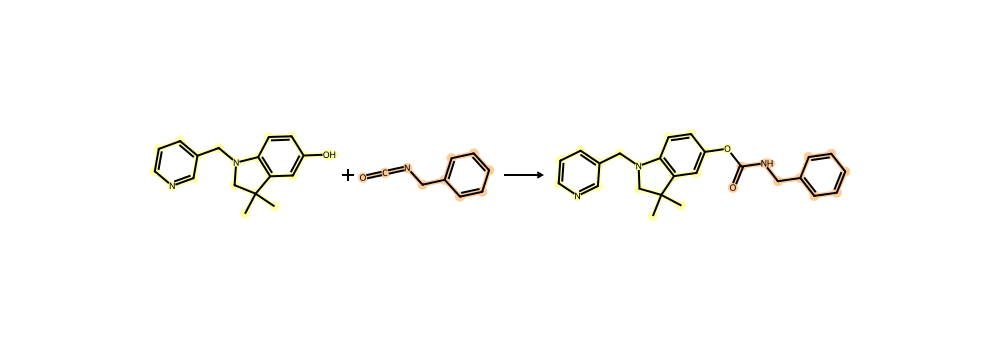

In [54]:
# Do any of the predictions match the "ground truth" (standardized rxn),
# meaning do the candidate reactants match the test reaction reactants?
# See notes earlier and in self-study section of notebook
# Here is the "ground truth" rxn (note that the predictions are retro, so reversed)
with open("test_rxn1.rsmi") as infile:
     line = infile.readline()
     ground_truth_smiles, id = line.split(' ')
rxn = rdChemReactions.ReactionFromSmarts(ground_truth_smiles,useSmiles=True)
rdChemReactions.SanitizeRxn(rxn)
drawer = rdMolDraw2D.MolDraw2DSVG(1000,350)
drawer.DrawReaction(rxn,highlightByReactant=True)
drawer.FinishDrawing()
display(SVG(drawer.GetDrawingText()))

In [55]:
# Get the reactants to test if a match
if ">>" in ground_truth_smiles:
   ground_truth_reactants, product = ground_truth_smiles.split(">>")
elif ">" in ground_truth_smiles:
   ground_truth_reactants, agents, product = ground_truth_smiles.split(">")

# remove atom maps and canonicalize with RDKit
def remove_atom_mapping(smiles):
    """
    Remove atom mapping from smiles
    """
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        atom.ClearProp('molAtomMapNumber')
    return Chem.MolToSmiles(mol)

canonical_ground_truth_reactants = remove_atom_mapping(ground_truth_reactants)
canonical_ground_truth_reactants

'CC1(C)CN(Cc2cccnc2)c2ccc(O)cc21.O=C=NCc1ccccc1'

In [56]:
# canonicalize prediction reactants with RDKit
from pprint import pprint
for key, value in filtered_predictions.items():
    for idx, prediction in enumerate(value['predictions']):
        prediction["canonical_rdkit_reactants"] = remove_atom_mapping(prediction["Reactants"])
        
       # check if it matches ground truth and print if True
        if prediction["canonical_rdkit_reactants"] == canonical_ground_truth_reactants:
           prediction["matches ground truth"] = True
           pprint("Sequence" + str(idx))
           pprint(value["predictions"][idx])
        else:
           prediction["matches ground truth"] = False


'Sequence6'
{'Reactants': 'Oc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C.O=C=NCc1ccccc1',
 'Retro Type': 'ALL',
 'Signature': '[10035O]=[7447C]([13443O][4982C])[10449N][4039C]',
 'Template': 'US20020052498A1__3305',
 'canonical_rdkit_reactants': 'CC1(C)CN(Cc2cccnc2)c2ccc(O)cc21.O=C=NCc1ccccc1',
 'matches ground truth': True,
 'predicted_rxn_smi': 'CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1>>Oc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C.O=C=NCc1ccccc1'}


## Run Retrosynthesis Prediction on testing data

In [57]:
# Now we will try retrosynthesis template prediction on the ~9,000 test products
# Split data into reactants, agents, and product
"""
reactants>agents>product    ID
reactants>>product  ID

"""

testing_reaction_data = []
with open("_rxns_std_testing.rsmi", 'r') as infile:
    for line in infile:
        if ">>" in line:
            rxn, id = line.split()
            reactants, product = rxn.split(">>")
            testing_reaction_data.append({
                'reactants': reactants,
                'product': product,
                'id': id
            })
            continue
        if ">" in line:
            rxn, id = line.split()
            reactants, agents, product = rxn.split(">")
            testing_reaction_data.append({
                'reactants': reactants,
                'agents': agents,
                'product': product,
                'id': id
            })
            continue

In [58]:
len(testing_reaction_data)

8971

In [59]:
testing_reaction_data[0]

{'reactants': 'Br[CH2:1][C:2](=[O:3])[NH:4][C:5]1=[CH:6][CH:7]=[C:8]([C:9]2=[N:10][C:11]3=[C:17]([CH:16]=[CH:15][C:13](=[CH:12]3)[Cl:14])[O:18]2)[CH:19]=[CH:20]1.[OH:21][C:22]1=[CH:23][CH:24]=[CH:25][C:26]([F:27])=[CH:28]1',
 'product': '[CH2:1]([C:2](=[O:3])[NH:4][C:5]1=[CH:6][CH:7]=[C:8]([C:9]2=[N:10][C:11]3=[C:17]([CH:16]=[CH:15][C:13](=[CH:12]3)[Cl:14])[O:18]2)[CH:19]=[CH:20]1)[O:21][C:22]1=[CH:23][CH:24]=[CH:25][C:26]([F:27])=[CH:28]1',
 'id': 'US08334290B2__22903'}

In [60]:
# write products to a file (this will be our targets for the predictions)
with open("_testing_product_smiles.smi", 'w') as outfile:
    for item in testing_reaction_data:
        outfile.write(item['product'] + ' ' + item['id'] + '\n')

In [61]:
# Now run retrosynthesis, this will test each target product against the list of templates in RRT_T10
retro = lillymol_path + "retrosynthesis -Z -z -Y all -X rmiso -X kg -X kekule -X ersfrm " \
     + "-a 2 -q f -v -R 1 -I _RRT_T10 -P UST:AZUCORS _testing_product_smiles.smi > _prediction_all.rsmi 2> _prediction_all.log"
subprocess.call([retro], shell=True)

0

In [62]:
"""
dictionary = {
    "parent_id": {
        "product": "",
        "predictions": [
            {
                "Reactants": ""
                "Template": "US05874436__5947"
                "Retro Type": "ALL" or "SPFRM.1" or "SPFRM.0"
            }
        ]
}
"""

# parse prediction data into a dictionary
predictions_testing = {}
with open("_prediction_all.rsmi", 'r') as infile:
    for line in infile:
        prediction_data = line.strip().split()
        if prediction_data[-1] == "PARENT":
            product = prediction_data[0]
            parent_id = prediction_data[1]
            if parent_id not in predictions_testing:

                predictions_testing[parent_id] = {
                    "product": product,
                    "predictions": []
                }
            continue


        if prediction_data[-1] != "PARENT": #, "SPFRM.1", "SPFRM.0"]:
            reactants = prediction_data[0]
            parent_id = prediction_data[1]
            retro_type = prediction_data[-1]
            template = prediction_data[3]
            signature = prediction_data[4]
            predictions_testing[parent_id]["predictions"].append({
                "Reactants": reactants,
                "Template": template,
                "Signature": signature,
                "Retro Type": retro_type
            })

In [63]:
# Filter for retro type ALL
filtered_predictions_all = {
   key: {
       'product': value['product'],
       'predictions': [pred for pred in value['predictions'] if pred['Retro Type'] == 'ALL'],
       'count': sum(1 for pred in value['predictions'] if pred['Retro Type'] == 'ALL')
   }
   for key, value in predictions_testing.items()
}

In [ ]:
# Filter for retro type SPFRM.1 or SPFRM.0
# filtered_predictions_all = {
#     key: {
#         'product': value['product'],
#         'predictions': [
#             pred for pred in value['predictions']
#             if pred['Retro Type'] in ('SPFRM.1', 'SPFRM.0')
#         ],
#         'count': sum(
#             1 for pred in value['predictions']
#             if pred['Retro Type'] in ('SPFRM.1', 'SPFRM.0')
#         )
#     }
#     for key, value in predictions_testing.items()
# }

In [64]:
# Add reaction syntax
# Create rxn syntax for predictions
for key,value in filtered_predictions_all.items():
    product = value['product']
    for prediction in value['predictions']:
        rxn = product + ">>" + prediction["Reactants"] 
        prediction["predicted_rxn_smi"] = rxn

In [65]:
list(filtered_predictions_all.items())[0]

('US08334290B2__22903',
 {'product': 'C(C(=O)NC1=CC=C(C2=NC3=C(C=CC(=C3)Cl)O2)C=C1)OC1=CC=CC(F)=C1',
  'predictions': [{'Reactants': 'Cl.Clc1cc2[n]c(oc2cc1)c1ccc(N)cc1.Fc1cccc(OCC=O)c1',
    'Template': 'US07576104B2__7896',
    'Signature': '[10035O]=[7447C]([10449N][4982C])[4039C]',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C(C(=O)NC1=CC=C(C2=NC3=C(C=CC(=C3)Cl)O2)C=C1)OC1=CC=CC(F)=C1>>Cl.Clc1cc2[n]c(oc2cc1)c1ccc(N)cc1.Fc1cccc(OCC=O)c1'},
   {'Reactants': 'Cl.Clc1ccc2oc([n]c2c1)c1ccc(NC(=O)C)cc1.Fc1cc(O)ccc1',
    'Template': 'US06156914__3128',
    'Signature': '[10035O]=[4043C][7443C][13443O][4982C]',
    'Retro Type': 'ALL',
    'predicted_rxn_smi': 'C(C(=O)NC1=CC=C(C2=NC3=C(C=CC(=C3)Cl)O2)C=C1)OC1=CC=CC(F)=C1>>Cl.Clc1ccc2oc([n]c2c1)c1ccc(NC(=O)C)cc1.Fc1cc(O)ccc1'},
   {'Reactants': 'Cl.Clc1cc2[n]c(oc2cc1)c1ccc(NC(=O)CO)cc1.Fc1ccccc1',
    'Template': 'US06552012B2__42585',
    'Signature': '[4039C][13443O][8386C](:[4979C]):[4979C]::2,3:2,4:',
    'Retro Type': 'ALL',
    

In [ ]:
# Get top 10 (with many predictions)
# top_10 = dict(sorted(filtered_predictions_all.items(), key=lambda item: item[1]['count'], reverse=True)[:10])
# top_10

In [66]:
# count of total predictions
total_sum = 0
for key, value in filtered_predictions_all.items():
    total_sum += value["count"]
print(total_sum)

41880


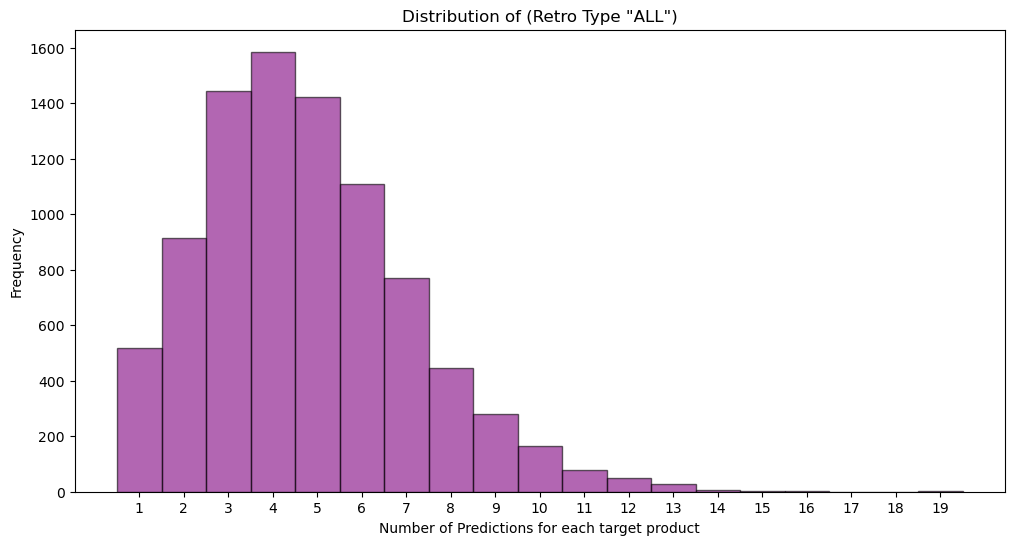

In [67]:
# show distribution of counts
import matplotlib.pyplot as plt

# Extract counts
counts = [value['count'] for value in filtered_predictions_all.values()]

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.hist(counts, bins=range(1, max(counts) + 2), edgecolor='black', align='left', color='purple', alpha=0.6)
plt.xlabel('Number of Predictions for each target product')
plt.ylabel('Frequency')
plt.title('Distribution of (Retro Type "ALL")')
plt.xticks(range(1, max(counts) + 1))
plt.show()

In [68]:
# Get number of targets that have at least one prediction
test_rxns = {}
with open("_rxns_std_testing.rsmi", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 2:
            rxn, id = split_data
            test_rxns[id] = rxn

print(len(test_rxns))

count = 0
for parent_id, data in filtered_predictions_all.items():
    if parent_id in test_rxns:
        count+=1
print(count)

8971
8819


In [69]:
# Some targets have multiple predictions
total_predictions = 0
for parent_id, data in filtered_predictions_all.items():
    total_predictions += len(data['predictions'])
total_predictions

41880

## Self-Study

### Evaluation Comparison

In [70]:
# Some code to compare predictions to "ground truth" (standardized) test reactions
# But more thought needs to go into this, as it was not in the original article, and it is unclear
# how best to do the comparison and/or how relevant the comparison would be with the LillyMol RTSA algorithm.
# Our initial test with number of matches was low, but my guess is that with adjusting signature
# and threshold parameters, this could change significantly -- so this requires a bit more testing and thought.
# May also need to consider fragments vs. no fragments?

In [71]:
# "ground_truth" here is referring to the standardized reaction from the test data.
# So an important note is that they are not the original reactions from the patent data
# as they have been put through a standardization workflow. We also remove atom mapping first, 
# and then compare RDKit canonical smiles of predicted vs. ground truth

ground_truths = {}
with open("_rxns_std_testing.rsmi", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 2:
            rxn, id = split_data
            ground_truths[id] = rxn

len(ground_truths)

8971

In [72]:
# Get number of targets that have at least one prediction
count = 0
for parent_id, data in filtered_predictions_all.items():
    if parent_id in ground_truths:
        count+=1
print(count)

8819


In [73]:
# Some targets have multiple predictions
total_predictions = 0
for parent_id, data in filtered_predictions_all.items():
    total_predictions += len(data['predictions'])
total_predictions


41880

In [74]:
# function to remove atom maps and canonicalize with RDKit
def remove_atom_mapping(smiles):
    """
    Remove atom mapping from smiles
    """
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        atom.ClearProp('molAtomMapNumber')
    return Chem.MolToSmiles(mol, canonical=True)

In [76]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# using RDKit here for the comparison
# compare ground truth reactants to predicted reactants to see if they are the same
for parent_id, data in filtered_predictions_all.items():
    target = data['product']
    for prediction in data['predictions']:
        reactants = prediction['Reactants']
        template_id = prediction['Template']

        # Check if predicted reactants are the same as the ground truth

        if parent_id not in ground_truths:
            prediction["matches ground truth"] = False
            continue
        ground_truth = ground_truths[parent_id]
        ground_truth_reactants = None
        if ">>" in ground_truth:
            ground_truth_reactants = ground_truth.split(">>")[0]
        elif ">" in ground_truth:
            ground_truth_reactants = ground_truth.split(">")[0]

        # canonicalize the smiles
        try:
            canonical_predicted_reactants = remove_atom_mapping(reactants)
        except Exception as e:
            prediction["matches ground truth"] = "Could not canonicalize predicted reactants"
            continue
        try:
            canonical_ground_truth_reactants = remove_atom_mapping(ground_truth_reactants)
        except Exception as e:
            prediction["matches ground truth"] = "Could not canonicalize ground truth"
            continue

        prediction["matches ground truth"] = canonical_predicted_reactants == canonical_ground_truth_reactants
        prediction["canonical_predicted_reactants"] = canonical_predicted_reactants
        prediction["canonical_ground_truth_reactants"] = canonical_ground_truth_reactants

In [77]:
# How many predictions match ground truth?
match = 0
for key, value in filtered_predictions_all.items():
    for prediction in value['predictions']:
        if prediction['matches ground truth']:
            match += 1
print(f"Number of matches: {match}")


Number of matches: 231


### Precedent Reactions for Reference

Something interesting we can do mentioned in ref [3] (Nicolaou, C. A. et al. J. Chem. Inf. Model. 2020, 60 (6), 2728–2738. https://doi.org/10.1021/acs.jcim.9b01141.) is to look at the precedent reactions associated with a prediction sequence (a cluster of rxns associated with a unique signature). Note that here for demonstration, the precedent reactions we will look at are not the original reactions from the training, they are the standardized and modified reactions from our workflow above.

In [78]:
# We have a dictionary of the filtered signatures
# We can get all precedent reactions (from training) associated with a particular signature.
list(filtered_sig_count.items())[0:5]

[('[10035O]=[7447C]([10449N][4982C])[4909C]', 148),
 ('[7985N]:[8386C]([8386C](:[4979C]):[4979C]):[4979C]::0,1:1,5:2,3:2,4:', 170),
 ('[13439O]=[7447C]([4982C])[4034C]', 10),
 ('[5141C]:[11318N]([7443C][4982C]):[4909C]::0,1:1,4:', 44),
 ('[7042N]#[7445C][8386C](:[4982C]):[4979C]::2,3:2,4:', 20)]

In [79]:
print(len(filtered_sig_count))

553


In [80]:
# Let's load the signature file again and merge with the associated standardized SMILES

signatures = []
with open("_out_sig", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 6:
            sigrsmi, na, id, sigr0, sigr1, sigr2 = split_data
            signatures.append({
                'sigrsmi': sigrsmi,
                'na': na,
                'id': id,
                'sigr0': sigr0,
                'sigr1': sigr1,
                'sigr2': sigr2
            })

# pull out data from _rxns_std_training_reversed file and merge with cdf to get data
with open("_rxns_std_training_reversed", 'r') as infile:
    for line in infile:
        split_data = line.split()
        if len(split_data) == 2:
            stdrsmi, id = split_data
            for item in signatures:
                if item['id'] == id:
                    item['stdrsmi'] = stdrsmi
                    break

In [81]:
# Get the precedent rxns by signature
precedent_rxns = {}
for item in signatures:
    signature = item[radius]
    for sig,value in filtered_sig_count.items():
        if sig == signature:
            if sig not in precedent_rxns:
               precedent_rxns[sig] = {'count': value, 'reactions':[]}
            precedent_rxns[sig]['reactions'].append({'id': item['id'], 'stdrsmi': item['stdrsmi']})   

In [82]:
#list(precedent_rxns.items())[0]

In [83]:
total_precedent_rxns = 0
for sig, data in precedent_rxns.items():
    total_precedent_rxns += len(data['reactions'])
total_precedent_rxns

25081

In [84]:
# Now let's go back to our filtered_predictions_all
# and look at an example

ID = "US20110294850A1__24709" # target ID
filtered_predictions_all[ID]

{'product': 'CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1',
 'predictions': [{'Reactants': 'OC(=O)OC(C)(C)C.NCc1ccccc1.O=COc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C',
   'Template': 'US20140179567A1__16206',
   'Signature': '[10039O][7447C](=[10035O])[10449N][4039C]',
   'Retro Type': 'ALL',
   'predicted_rxn_smi': 'CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1>>OC(=O)OC(C)(C)C.NCc1ccccc1.O=COc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C',
   'matches ground truth': False,
   'canonical_predicted_reactants': 'CC(C)(C)OC(=O)O.CC1(C)CN(Cc2cccnc2)c2ccc(OC=O)cc21.NCc1ccccc1',
   'canonical_ground_truth_reactants': 'CC1(C)CN(Cc2cccnc2)c2ccc(O)cc21.O=C=NCc1ccccc1'},
  {'Reactants': 'Cl.O=C(Oc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C)NCc1ccccc1',
   'Template': 'US20090156642A1__16890',
   'Signature': '[7985N]:[8383C]:[4979C]::0,1:1,2:',
   'Retro Type': 'ALL',
   'predicted_rxn_smi': 'CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1>>Cl.O=C(Oc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C)NCc1ccccc1',
   'mat

In [85]:
# first prediction
seq0_smiles = filtered_predictions_all[ID]["predictions"][0]["predicted_rxn_smi"]
seq0_smiles

'CC1(C)CN(CC2=CC=CN=C2)C2=C1C=C(C=C2)OC(=O)NCC1=CC=CC=C1>>OC(=O)OC(C)(C)C.NCc1ccccc1.O=COc1cc2C(CN(c2cc1)Cc1c[n]ccc1)(C)C'

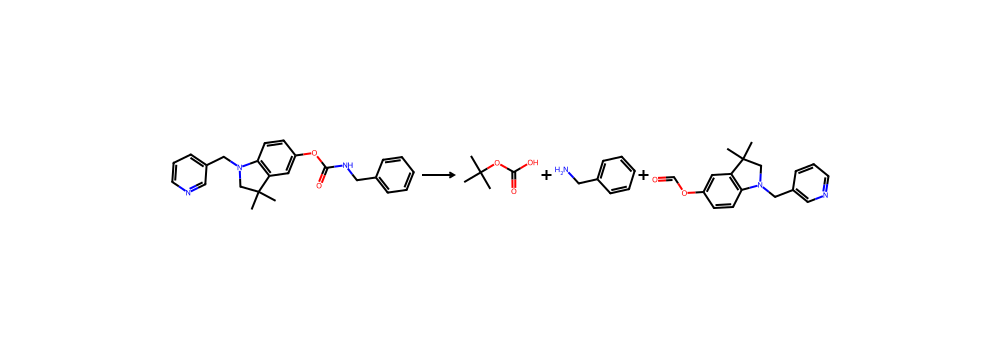

In [86]:
# Look at first predicted reaction
rxn = rdChemReactions.ReactionFromSmarts(seq0_smiles,useSmiles=True)
rdChemReactions.SanitizeRxn(rxn)
drawer = rdMolDraw2D.MolDraw2DSVG(1000,350)
drawer.drawOptions().addStereoAnnotation = False
drawer.DrawReaction(rxn,highlightByReactant=False)
drawer.FinishDrawing()
display(SVG(drawer.GetDrawingText()))

In [87]:
# Get the signature used
seq0_signature = filtered_predictions_all[ID]["predictions"][0]["Signature"]
seq0_signature

'[10039O][7447C](=[10035O])[10449N][4039C]'

In [88]:
# Now get the list of precedent reactions associated with this signature
# We can get the precedent reactions like this:
Seq0_precedent_rxns = precedent_rxns[seq0_signature]

# number of precedent reactions
list(Seq0_precedent_rxns.items())[0]

('count', 74)

In [89]:
# We need to do a few things:

# 1. We need to convert the precedent reactions + component SMILES to .
# 2. We need a way to rank the reactions, we will use rdkit reaction fingerprints
#    to compare the predicted rxn to precedent reactions similarity

for reaction in Seq0_precedent_rxns["reactions"]:
    id = reaction['id']
    precedent_rxn_plus = reaction['stdrsmi']

    with open("_temp_plus_smiles", "w") as outfile:
        outfile.write(precedent_rxn_plus + "\n")
    # convert + to .    
    cmd = [lillymol_path+"rxn_standardize", "-d", "d", "-s", "_temp_plus_smiles"]
    try:
        # Run the command
        precident_reaction_period = subprocess.check_output(cmd, text=True)
        reaction["stdrsmi_periods"] = precident_reaction_period.strip()
    except subprocess.CalledProcessError as e:
            print(f"Error standardizing reaction: {e.output}")

In [90]:
# We will compare the precedent reactions to the sequence 0 prediction
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

Seq0_predicted_smiles = filtered_predictions_all[ID]["predictions"][0]["predicted_rxn_smi"]

for reaction in Seq0_precedent_rxns["reactions"]:
    id = reaction['id']
    precedent_smiles = reaction['stdrsmi_periods']

    # compute reaction similarity based on fingerprints
    # WARNING: I don't think mapping numbers matter
    # However, agents do influence rxn fingerprint, I'm leaving them out here
    # as the predicted reactions do not have agents

    # Set up ReactionFingerprintParams with includeAgents=False
    params = rdChemReactions.ReactionFingerprintParams()
    params.includeAgents = False  # Do not include agents
    params.fpSize = 2048          # Size of the fingerprint
    params.fpType = rdChemReactions.FingerprintType.AtomPairFP
    
    try:
        predicted_rxn = rdChemReactions.ReactionFromSmarts(Seq0_predicted_smiles, useSmiles=True)
        rdChemReactions.SanitizeRxn(predicted_rxn)

        precedent_rxn = rdChemReactions.ReactionFromSmarts(precedent_smiles, useSmiles=True)
        rdChemReactions.SanitizeRxn(precedent_rxn)

        # Calculate the difference fingerprint
        predicted_fp = rdChemReactions.CreateDifferenceFingerprintForReaction(predicted_rxn, params)
        precedent_fp = rdChemReactions.CreateDifferenceFingerprintForReaction(precedent_rxn, params)

        similarity = AllChem.DataStructs.TanimotoSimilarity(precedent_fp, predicted_fp)
        reaction["similarity"] = similarity
    except:
        reaction["similarity"] = -1 # failure

In [91]:
# sort by highest similarity
sorted_reactions = sorted(Seq0_precedent_rxns['reactions'], key=lambda x: x['similarity'], reverse=True)

# Updating the dictionary with the sorted reactions
Seq0_precedent_rxns['reactions'] = sorted_reactions

In [ ]:
#Seq0_precedent_rxns

precedent reaction: US20090227799A1__43028
similarity: 0.28338762214983715


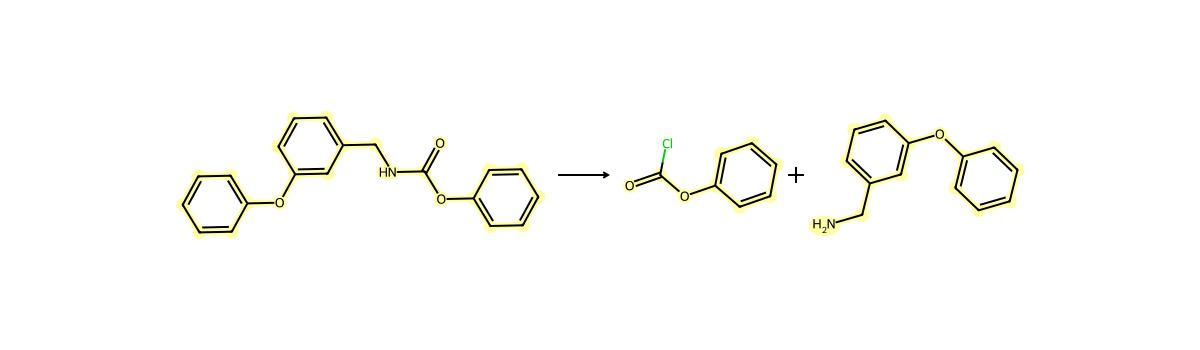

precedent reaction: US07067541B2__35210
similarity: 0.22377622377622378


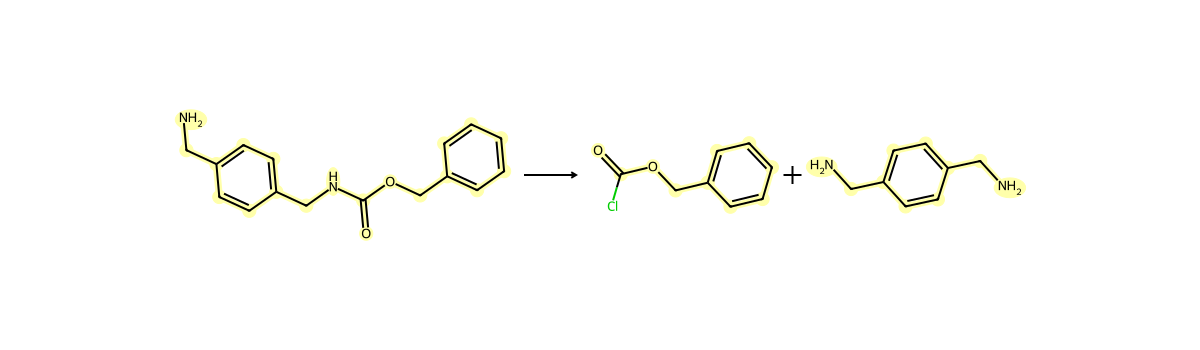

precedent reaction: US20090082434A1__17201
similarity: 0.2127659574468085


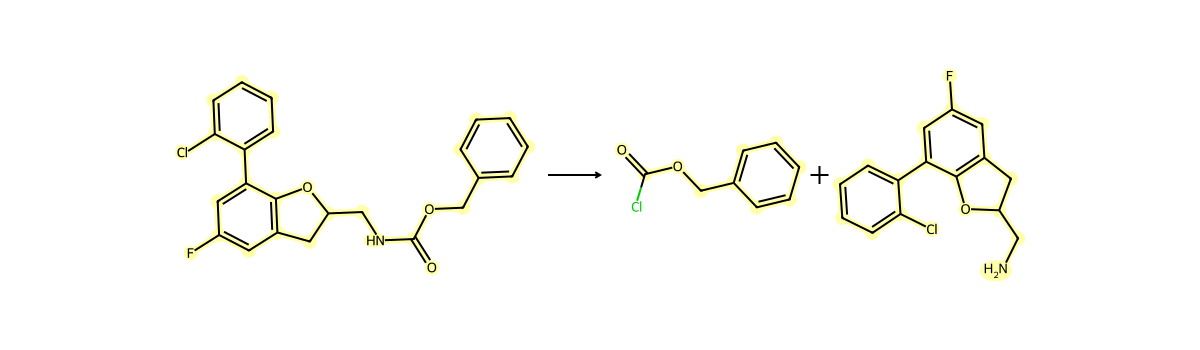

precedent reaction: US20110009454A1__32316
similarity: 0.19786096256684493


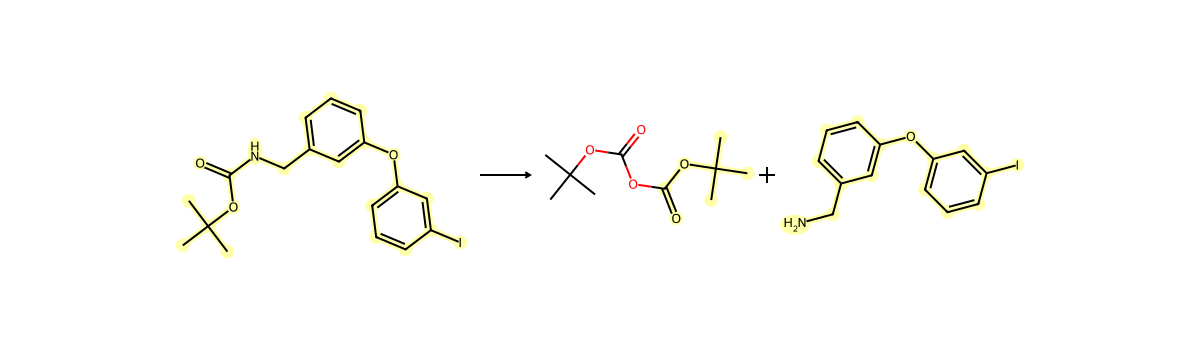

precedent reaction: US20040192653A1__6477
similarity: 0.195


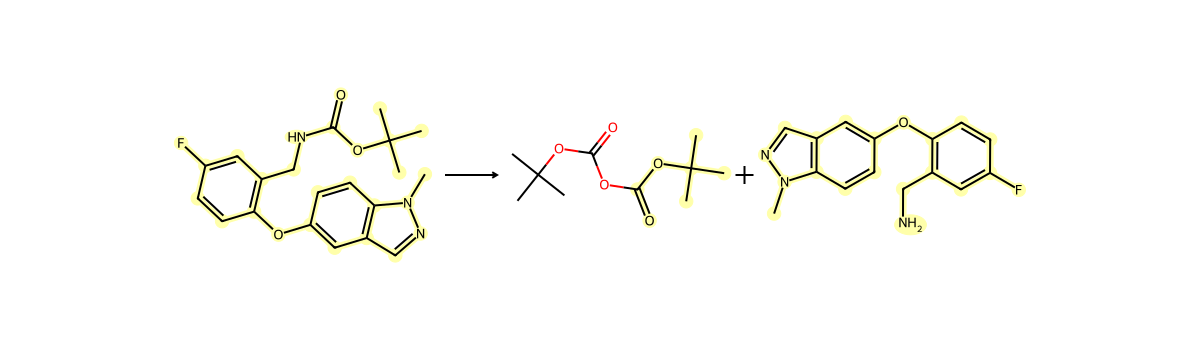

precedent reaction: US06025372__48818
similarity: 0.19230769230769232


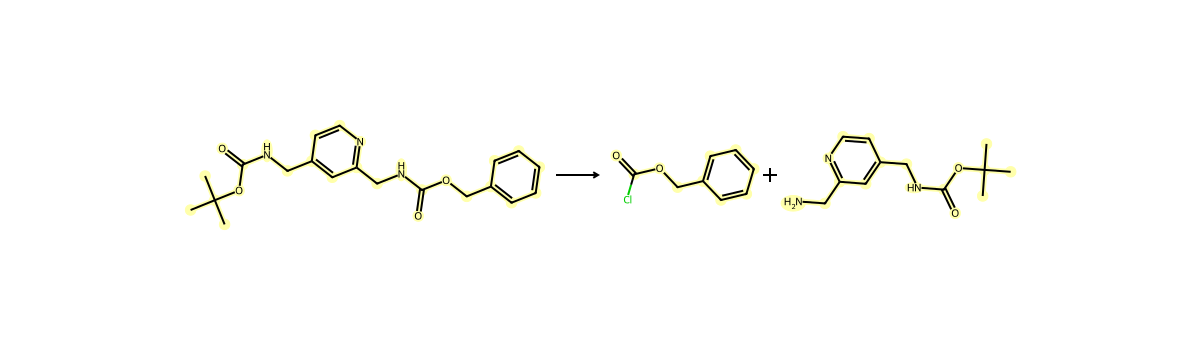

precedent reaction: US20130005964A1__35654
similarity: 0.1887905604719764


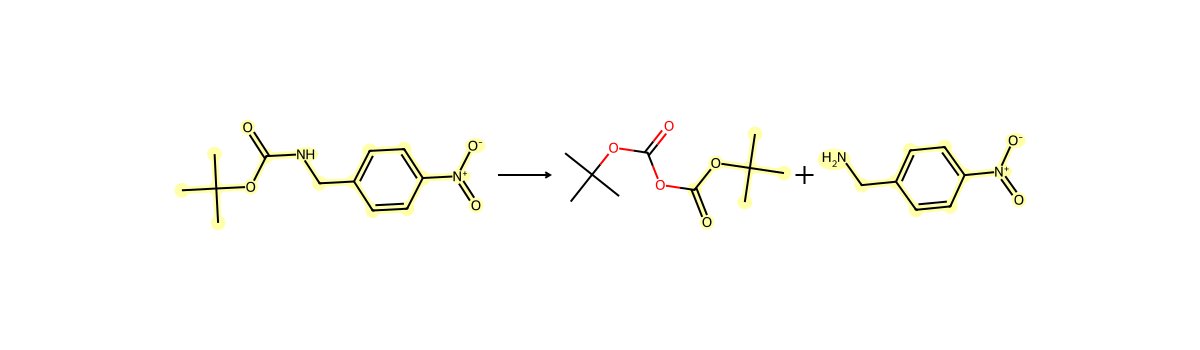

precedent reaction: US20060264415A1__17199
similarity: 0.1882716049382716


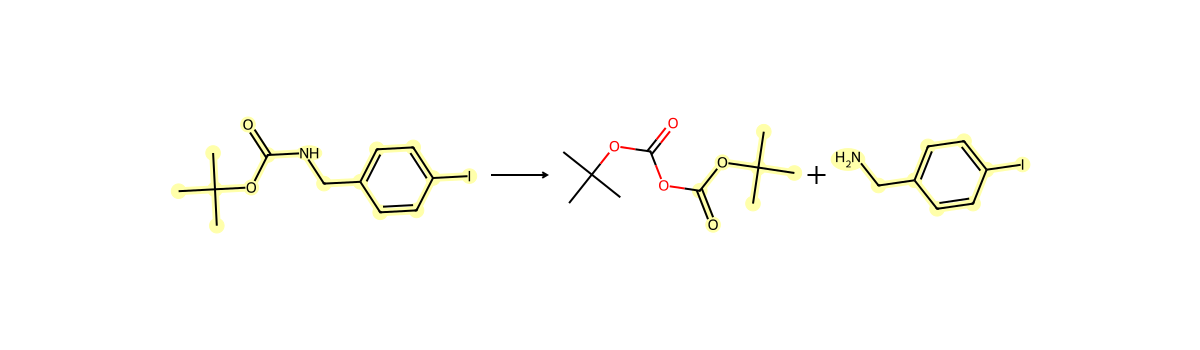

precedent reaction: US20080076924A1__14108
similarity: 0.1872791519434629


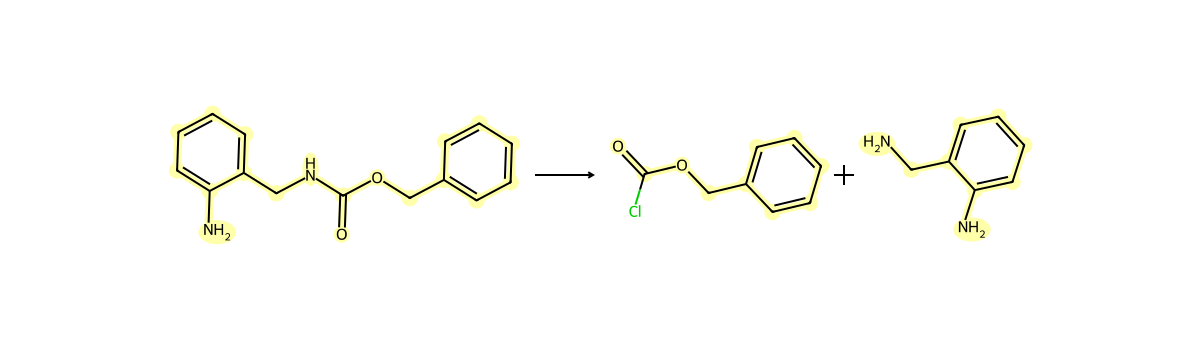

precedent reaction: US05594135__23410
similarity: 0.1760299625468165


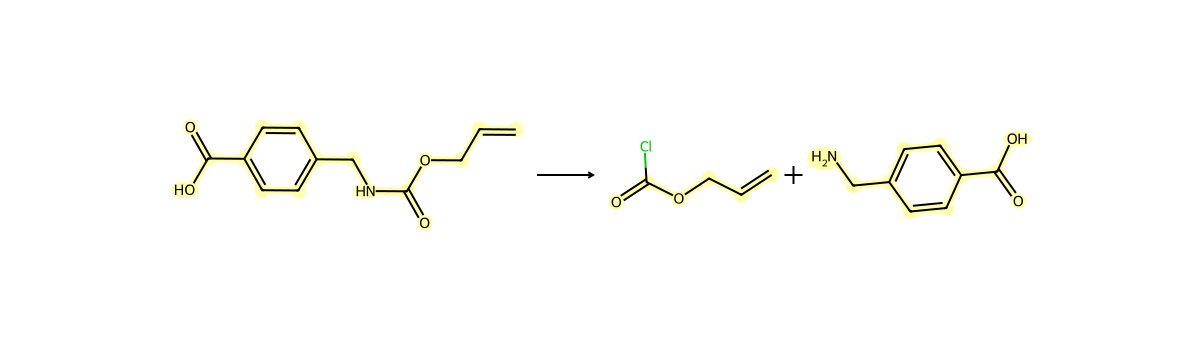

precedent reaction: US20050026929A1__24370
similarity: 0.17582417582417584


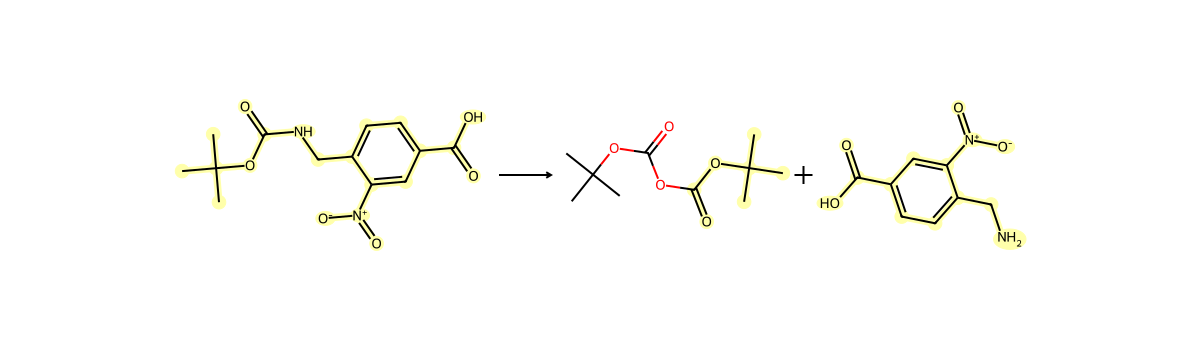

In [92]:
# finally, grab the top 10 precedent reactions and plot them
# Again, the "precedent" reactions are not the original reactions from the training set;
# they are the standardized and modified reactions.
# This is similarity of precedent rxn to predicted rxn
for idx, reaction in enumerate(Seq0_precedent_rxns["reactions"]):
    if idx <=10:
       print("precedent reaction: " + reaction["id"] + "\n" + "similarity: " + str(reaction["similarity"]))
       rxn = rdChemReactions.ReactionFromSmarts(reaction["stdrsmi_periods"],useSmiles=True)
       rdChemReactions.SanitizeRxn(rxn)
       drawer = rdMolDraw2D.MolDraw2DSVG(1200,350)
       drawer.DrawReaction(rxn,highlightByReactant=True)
       drawer.FinishDrawing()
       display(SVG(drawer.GetDrawingText()))